In [1]:
import geopy
import geopandas as gpd
import requests
import rasterio 
import rioxarray 
import json
import csv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline
import time
start = time.time()


from shapely import geometry

/home/arfa/.local/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
#address1 = 'ferdinand coosemansstraat 123 2600 berchem'
#request = requests.get(f"https://loc.geopunt.be/geolocation/location?q={address1}").json()
#print(request)

# Create a csv file to store bounds of each DTM/DSM file.

In [3]:
"""Create a csv file that reads each tif file and stores the bounds of 
   each one of them as a rown in the .csv file
"""

with open('bounds.csv', 'w', newline='') as file:
    writer = csv.writer(file, delimiter=",")
    writer.writerow(["File_number", "Bounds:Left", "Bounds:Bottom" , "Bounds:Right" , "Bounds:Top"])
    
for i in range(1,27):
    if i < 10:
        df = rasterio.open(f"DSM/DSM_k0{i}.tif")
        #print(i, df.bounds.left, df.bounds.bottom, df.bounds.right, df.bounds.top)
        with open ("bounds.csv", 'a', newline='') as file:
            writer = csv.writer(file, delimiter=",")
            writer.writerow([i , df.bounds.left , df.bounds.bottom , df.bounds.right , df.bounds.top])
        
    else:
        df = rasterio.open(f"DSM/DSM_k{i}.tif")
        #print(i, df.bounds.left, df.bounds.bottom, df.bounds.right, df.bounds.top)
        with open ("bounds.csv", 'a', newline='') as file:
            writer = csv.writer(file, delimiter=",")
            writer.writerow([i , df.bounds.left , df.bounds.bottom , df.bounds.right , df.bounds.top])

In [4]:
bounds = pd.read_csv("bounds.csv")
bounds.head()

,File_number,Bounds:Left,Bounds:Bottom,Bounds:Right,Bounds:Top
0,1,145000.0,238000.0,162000.0,247000.0
1,2,162000.0,238000.0,194000.0,250000.0
2,3,194000.0,238000.0,206000.0,248000.0
3,4,53000.0,218000.0,66000.0,225500.0
4,5,66000.0,218000.0,98000.0,232000.0


# To get the coordinates of a given address.

In [5]:
address =  input("Enter an address: ")
def details(address: str):
    req = requests.get(f"https://loc.geopunt.be/v4/Location?q={address}").json()
    info = {'address' : address, 
                'x_value' : req['LocationResult'][0]['Location']['X_Lambert72'],
                'y_value' : req['LocationResult'][0]['Location']['Y_Lambert72'],
                'street' : req['LocationResult'][0]['Thoroughfarename'],
                'house_number' : req['LocationResult'][0]['Housenumber'], 
                'postcode': req['LocationResult'][0]['Zipcode'], 
                'municipality' : req['LocationResult'][0]['Municipality']}
    
    detail = requests.get("https://api.basisregisters.vlaanderen.be/v1/adresmatch", 
                          params={"postcode": info['postcode'], 
                                  "straatnaam": info['street'],
                                  "huisnummer": info['house_number']}).json()
    building = requests.get(detail['adresMatches'][0]['adresseerbareObjecten'][0]['detail']).json()
    build = requests.get(building['gebouw']['detail']).json()
    info['polygon'] = [build['geometriePolygoon']['polygon']['coordinates']]
    
    return info

info = details(address)
info

Enter an address: spijker 29 2910 Essen


{'address': 'spijker 29 2910 Essen',
 'x_value': 157393.34,
 'y_value': 238631.92,
 'street': 'Spijker',
 'house_number': '29',
 'postcode': '2910',
 'municipality': 'Essen',
 'polygon': [[[[157385.82356835902, 238625.82755954564],
    [157398.8194083646, 238626.23434354737],
    [157398.5548323691, 238632.56855155155],
    [157400.88174436986, 238632.57085555047],
    [157400.87611237168, 238638.64675955474],
    [157393.11956836283, 238638.70410355553],
    [157393.09358436614, 238635.6356875524],
    [157386.00827235729, 238635.4543115534],
    [157385.82356835902, 238625.82755954564]]]]}

# To check which tiff file contains the address location.

In [6]:
# check which tif contains the location to identify the DSM/DTM file.
x = info["x_value"]
y = info["y_value"]

def check_DSM_DTM(x,y):
    for i in range(0,26):
        if (x >= bounds.loc[i, 'Bounds:Left'] and x <= bounds.loc[i,'Bounds:Right']) & \
           (y >= bounds.loc[i, 'Bounds:Bottom'] and y <= bounds.loc[i, 'Bounds:Top']):
            
            global res
            res = i+1
            if i < 9:
                print(f"The house is in this tif --> DSM_k0{i+1}.tif")
                return f"DSM/DSM_k0{i+1}.tif"
                
            
            else:
                print(f"The house is in this tif --> DSM_k{i+1}.tif")
                return f"DSM/DSM_k{i+1}.tif"
                            
result = check_DSM_DTM(x,y)
print(result)
if res < 10:
    resultDTM = f"DTM/DTM_k0{res}.tif"
else:
    resultDTM = f"DTM/DTM_k{res}.tif"
print(resultDTM)

The house is in this tif --> DSM_k01.tif
DSM/DSM_k01.tif
DTM/DTM_k01.tif


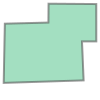

In [7]:
polygon = info["polygon"]
poly = geometry.Polygon(polygon[0][0])
poly

# To plot the chm and then plot the 3D model.

In [8]:
clipped = [ {'type': 'Polygon','coordinates': polygon[0]}]
dsm = rioxarray.open_rasterio(result, masked =True).rio.clip(clipped, from_disk=True)
#dsm.plot()


In [9]:
dtm = rioxarray.open_rasterio(resultDTM,masked=True).rio.clip(clipped, from_disk=True)
#dtm.plot()


(14, 16)


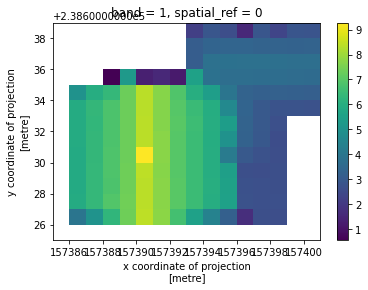

In [10]:
clipped_chm = dsm - dtm # To get the chm of the house.
clipped_chm.plot()

chm = clipped_chm[0]
print(chm.shape)  # To check if its a 2D array.

chm1 = np.where(np.isnan(chm), 0, chm) # Filling all the nan values with 0.

chm_ = np.pad(chm1, pad_width = 1, mode = "constant", constant_values = 0) # Giving it a padding of 0's around the border to get the image.
#chm_

rchm = np.fliplr(chm_) # Invert the house model

<IPython.core.display.Javascript object>


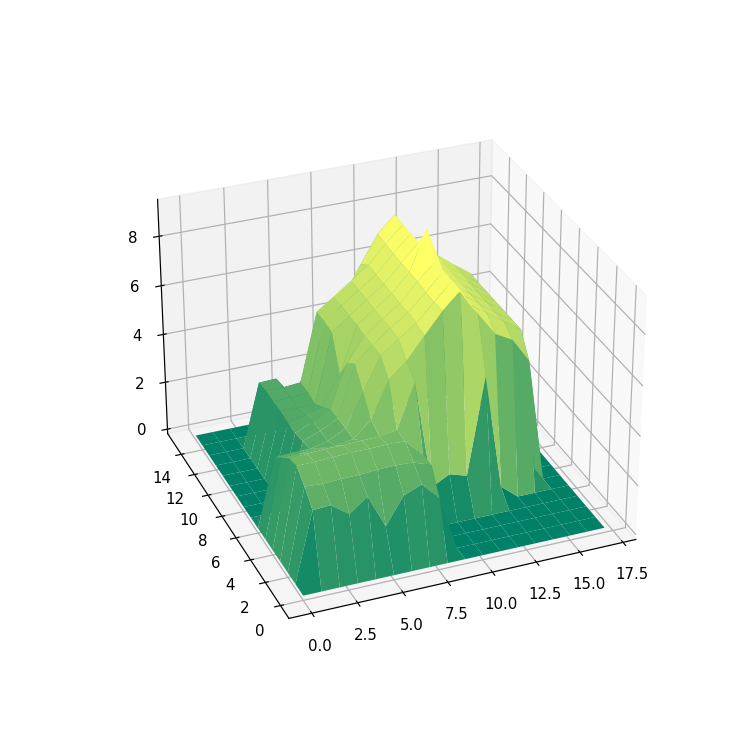

224.56213665008545


In [11]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib import animation
#from matplotlib.animation import FuncAnimation, MovieWriter
%matplotlib notebook

ny = rchm.shape[0]
nx = rchm.shape[1]
x = range(nx)
y = range(ny)
x1, y1 = np.meshgrid(x, y)
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111, projection='3d')
chm3d = ax.plot_surface(x1, y1, rchm,cmap = cm.summer, linewidth=0.1,)

#plt.show()
def rotate(angle):
    ax.view_init(azim=angle) 
    plt.draw()
    plt.pause(.001)
    
rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(0,362,2),interval=100)
rot_animation.save(f"{address}.gif")
plt.show()


end = time.time()
print(end - start)